# Learning LJ potential
This script learns a pair potential (e.g., Lennard-Jones) from MD simulations by optimizing against RDFs and VACFs. It uses automatic differentiation, molecular dynamics, and graph-based optimizations for learning transferable potentials.

In [33]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.lattice.cubic import FaceCenteredCubic, Diamond

from ase.visualize import *
from data_src.data import *
from potential_src.pairMLP.potential_PairMLP import *
from observables.rdf import *
from observables.observers import *   
from utils.get_utils import *

In [34]:
pair_data_dict = {  'lj_0.3_1.2': {
            'rdf_fn': '../data/LJ_data/rdf_rho0.3_T1.2_dt0.01.csv' ,
            'vacf_fn': '../data/LJ_data/vacf_rho0.3_T1.2_dt0.01.csv' ,
            'rho': 0.3,
            'T': 1.2, 
            'start': 0.75, 
            'end': 3.3,
            'element': "H",
            'mass': 1.0,
            "N_unitcell": 4,
            "cell": FaceCenteredCubic,
            "target_pot": LennardJones()
            },
  }

width_dict = {'tiny': 64,
               'low': 128,
               'mid': 256, 
               'high': 512}

gaussian_dict = {'tiny': 16,
               'low': 32,
               'mid': 64, 
               'high': 128}

In [3]:
class LJFamily(torch.nn.Module):
    def __init__(self, sigma=1.0, epsilon=1.0, attr_pow=6,  rep_pow=12):
        super(LJFamily, self).__init__()
        self.sigma = torch.nn.Parameter(torch.Tensor([sigma]))
        self.epsilon = torch.nn.Parameter(torch.Tensor([epsilon]))
        self.attr_pow = attr_pow
        self.rep_pow = rep_pow 

    def LJ(self, r, sigma, epsilon):
        return 4 * epsilon * ((sigma/r)**self.rep_pow - (sigma/r)**self.attr_pow)

    def forward(self, x):
        return self.LJ(x, self.sigma, self.epsilon)

In [4]:
def plot_vacf(vacf_sim, vacf_target, fn, path, dt=0.01, save_data=False):

    t_range = np.linspace(0.0,  vacf_sim.shape[0], vacf_sim.shape[0]) * dt 

    plt.plot(t_range, vacf_sim, label='simulation', linewidth=4, alpha=0.6, )

    if vacf_target is not None:
        plt.plot(t_range, vacf_target, label='target', linewidth=2,linestyle='--', c='black' )

    plt.legend()
    plt.show()

    if save_data:
         np.savetxt(path + '/vacf_{}.txt'.format(fn), np.stack((t_range, vacf_sim)), delimiter=',' )
         np.savetxt(path + '/vacf_{}_target.txt'.format(fn), np.stack((t_range, vacf_target)), delimiter=',' )

    plt.savefig(path + '/vacf_{}.pdf'.format(fn), bbox_inches='tight')
    plt.close()

def plot_rdf( g_sim, rdf_target, fn, path, start, nbins, save_data=False, end=2.5):

    bins = np.linspace(start, end, nbins)

    plt.plot(bins, g_sim , label='simulation', linewidth=4, alpha=0.6)
    plt.plot(bins, rdf_target , label='target', linewidth=2,linestyle='--', c='black')
    
    plt.xlabel("$\AA$")
    plt.ylabel("g(r)")

    if save_data:
        np.savetxt(path + '/rdf_{}.txt'.format(fn), np.stack((bins, g_sim)), delimiter=',' )
        np.savetxt(path + '/rdf_{}_target.txt'.format(fn), np.stack((bins, rdf_target)), delimiter=',' )

    plt.show()
    plt.savefig(path + '/rdf_{}.pdf'.format(fn), bbox_inches='tight')
    plt.close()


In [5]:
'''
Jensen-Shannon (JS) divergence between two radial distribution functions (RDFs),
 g_obs (observed/simulated RDF) and g (target/ground truth RDF)
'''
def JS_rdf(g_obs, g):
    e0 = 1e-5
    g_m = 0.5 * (g_obs + g)
    loss_js =  ( -(g_obs + e0 ) * (torch.log(g_m + e0 ) - torch.log(g_obs +  e0)) ).mean()
    loss_js += ( -(g + e0 ) * (torch.log(g_m + e0 ) - torch.log(g + e0) ) ).mean()

    return loss_js


In [6]:
def get_unit_len(rho, N_unitcell):
 
    L = (N_unitcell / rho) ** (1/3)
    
    return L 


In [7]:
def lattice_2d(rho, size):

    L = np.sqrt(size ** 2 / rho)/size # compute cell dim
    v1 = np.array([0,  1., 0.]) * L
    v2 = np.array([1., 0., 0.]) * L

    positions = []
    for i in range(size):
        for j in range(size):
            xyz = np.array(v1) * i + np.array(v2) * j
            positions.append(xyz)
            
    cell_len = L * size        
    cell = np.diag([cell_len] * 3)
    positions = np.array( positions )

    return positions, cell

## System Definition

In [8]:
def get_system(data_str, device, size):


    rho = pair_data_dict[data_str]['rho']
    T = pair_data_dict[data_str]['T']

    dim = pair_data_dict[data_str].get("dim", 3)

    if dim == 3:
        # initialize states with ASE 
        cell_module = pair_data_dict[data_str]['cell']
        N_unitcell = pair_data_dict[data_str]['N_unitcell']

        L = get_unit_len(rho, N_unitcell)

        print("lattice param:", L)

        atoms = cell_module(symbol=pair_data_dict[data_str]['element'],
                                  size=(size, size, size),
                                  latticeconstant= L,
                                  pbc=True)
        system = System(atoms, device=device)
        system.set_temperature(T)

    elif dim == 2:
        positions, cell = lattice_2d(rho, pair_data_dict[data_str]['size'])
        
        print("2D system")
        print("Number of atoms:{}".format(positions.shape[0]))
        print("Cell dim: \n {}".format(cell))

        atoms = Atoms(numbers=[1.] * positions.shape[0], positions=positions, cell=cell, pbc=True)
        system = System(atoms, device=device, dim=2)
        system.set_temperature(T)

    return system 


In [9]:
'''
running molecular dynamics (MD) simulations using the ground truth potential and extracting target observables
'''

def get_target_obs(system, data_str, n_sim, rdf_range, nbins, t_range, dt, skip=25):
    
    print("simulating {}".format(data_str))
    device = system.device 
    # simulation setup
    target_pot = pair_data_dict[data_str]['target_pot'] # take target potential
    T = pair_data_dict[data_str]['T'] # take target temperature

    pot = PairPotentials(system, target_pot, cutoff=2.5, nbr_list_device=device).to(device)

    diffeq = NoseHooverChain(pot, 
            system,
            Q=50.0, 
            T=T,
            num_chains=5, 
            adjoint=True,
            topology_update_freq=1).to(system.device)

    # define simulator with 
    sim = Simulations(system, diffeq)

    rdf_obs = rdf(system, nbins=nbins, r_range=rdf_range)
    vacf_obs = vacf(system, t_range=t_range) 
    
    all_vacf_sim = []
    
    # Run MD Simulations & Extract Target Data
    for i in range(n_sim):
        v_t, q_t, pv_t = sim.simulate(100, dt=dt, frequency=100) # 100 time steps, dt is given with argparse are in fs, freq is how often the system's state is updated and logged during a md simulation.

        if i >= skip:
            vacf_sim = vacf_obs(v_t).detach().cpu().numpy()
            all_vacf_sim.append(vacf_sim)
            
    # loop over to compute observables 
    trajs = torch.Tensor( np.stack( sim.log['positions'])).to(system.device).detach()
    all_g_sim = []
    for i in range(len(trajs)):

        if i >= skip:
            _, _, g_sim = rdf_obs(trajs[[i]])
            all_g_sim.append(g_sim.detach().cpu().numpy())

    all_g_sim = np.array(all_g_sim).mean(0)
    all_vacf_sim = np.array(all_vacf_sim).mean(0)
    
    return all_g_sim, all_vacf_sim



In [10]:

def get_observer(system, data_str, nbins, t_range, rdf_start):

    # rdf_data_path = pair_data_dict[data_str]['rdf_fn']
    # rdf_data = np.loadtxt(rdf_data_path, delimiter=',')

    # if pair_data_dict[data_str].get("vacf_fn", None):
    #     vacf_data_path = pair_data_dict[data_str]['vacf_fn']
    #     vacf_target = np.loadtxt(vacf_data_path, delimiter=',')[:t_range]
    #     vacf_target = torch.Tensor(vacf_target).to(system.device)
    # else:
    #     vacf_target = None

    # get dt 
    dt = pair_data_dict[data_str].get('dt', 0.01)

    rdf_end = pair_data_dict[data_str].get("end", None)

    xnew = np.linspace(rdf_start , rdf_end, nbins)
        # initialize observable function 
    obs = rdf(system, nbins, (rdf_start , rdf_end) )
    vacf_obs = vacf(system, t_range=t_range) 

    # get experimental rdf 
    dim = pair_data_dict[data_str].get("dim", 3) 

    rdf_data_path = pair_data_dict[data_str].get("fn", None)
    # generate simulated data 
    if not rdf_data_path:
        rdf_data, vacf_target = get_target_obs(system, data_str, 200, (rdf_start, rdf_end), nbins=nbins, t_range=t_range, skip=50, dt=dt)
        vacf_target = torch.Tensor(vacf_target).to(system.device)
        rdf_data = np.vstack( (np.linspace(rdf_start, rdf_end, nbins), rdf_data))
    else:
        # experimental rdfs
        rdf_data = np.loadtxt(rdf_data_path, delimiter=',')
        vacf_target = None

    _, rdf_target = get_exp_rdf(rdf_data, nbins, (rdf_start, rdf_end), obs.device, dim=dim)

    # get model potential and simulate 

    return xnew, rdf_target, obs, vacf_target, vacf_obs


In [11]:

def get_sim(system, model, data_str, topology_update_freq=1):

    T = pair_data_dict[data_str]['T']

    diffeq = NoseHooverChain(model, 
            system,
            Q=50.0, 
            T=T,
            num_chains=5, 
            adjoint=True,
            topology_update_freq=topology_update_freq).to(system.device)

    # define simulator with 
    sim = Simulations(system, diffeq)

    return sim


In [12]:

def plot_pair(fn, path, model, prior, device, end=2.5, target_pot=None): 

    if target_pot is None:
        target_pot = LennardJones(1.0, 1.0)
    else:
        target_pot = target_pot.to("cpu")

    x = torch.linspace(0.1, end, 250)[:, None].to(device)
    
    u_fit = (model(x) + prior(x)).detach().cpu().numpy()
    u_fit = u_fit - u_fit[-1] 

    u_target = target_pot(x.detach().cpu()).squeeze()

    plt.plot( x.detach().cpu().numpy(), 
              u_fit, 
              label='fit', linewidth=4, alpha=0.6)
    
    plt.plot( x.detach().cpu().numpy(), 
              u_target.detach().cpu().numpy(),
               label='truth', 
               linewidth=2,linestyle='--', c='black')

    plt.ylim(-2, 4.0)
    plt.legend()      
    plt.show()
    plt.savefig(path + '/potential_{}.jpg'.format(fn), bbox_inches='tight')
    plt.close()

    return u_fit


The fit_lj function trains a neural network-based pair potential by optimizing it to match Radial Distribution Functions (RDFs) and Velocity Auto-Correlation Functions (VACFs) from MD simulations.

In [13]:
def fit_lj(assignments, suggestion_id, device, sys_params, project_name):

    n_epochs = sys_params['n_epochs'] 
    n_sim = sys_params['n_sim'] 
    size = sys_params['size']
    cutoff = sys_params['cutoff']
    t_range = sys_params['t_range']

    nbins = assignments['nbins']
    tau = assignments['opt_freq']

    rdf_start = assignments.get("start", 0.75)
    skip = 1

    nbr_list_device = sys_params.get("nbr_list_device", device)
    topology_update_freq = sys_params.get("topology_update_freq", 1)

    data_str_list = sys_params['data']

    # Get the grounth truth pair potentials
    target_pot = pair_data_dict[data_str_list[0]].get("target_pot", None)

    # merge paramset 
    if sys_params['val']:
        val_str_list = sys_params['val']
    else:
        val_str_list = []

    print(json.dumps(assignments, indent=1))

    model_path = '{}/{}'.format(project_name, suggestion_id)
    os.makedirs(model_path)

    # merge paramset 
    paramset = {**sys_params, **assignments}
    # dump paramset 
    with open(model_path + '/paramset.json', 'w') as fp:
        json.dump(paramset, fp, indent=4)

    print("Training for {} epochs".format(n_epochs))

    system_list = []
    for data_str in data_str_list + val_str_list:
        system = get_system(data_str, device, size) 
        system_list.append(system)

    # Define prior potential
    mlp_parmas = {'n_gauss': int(cutoff//assignments['gaussian_width']), 
              'r_start': 0.0,
              'r_end': cutoff, 
              'n_width': assignments['n_width'],
              'n_layers': assignments['n_layers'],
              'nonlinear': assignments['nonlinear']}

    lj_params = {'epsilon': assignments['epsilon'], 
         'sigma': assignments['sigma'],
        "power": assignments['power']}

    NN = pairMLP(**mlp_parmas)
    pair = LJFamily(epsilon=2.0, sigma=assignments['sigma'], rep_pow=6, attr_pow=3)  # ExcludedVolume(**lj_params)

    model_list = []
    for i, data_str in enumerate(data_str_list + val_str_list):

        pairNN = PairPotentials(system_list[i], NN,
                    cutoff=cutoff,
                    nbr_list_device=nbr_list_device
                    ).to(device)
        prior = PairPotentials(system_list[i], pair,
                        cutoff=2.5,
                    nbr_list_device=nbr_list_device
                        ).to(device)

        model = Stack({'pairnn': pairNN, 'pair': prior})
        model_list.append(model)


    sim_list = [get_sim(system_list[i], 
                        model_list[i], 
                        data_str,
                        topology_update_freq=topology_update_freq) for i, data_str in enumerate(data_str_list + val_str_list)]

    

    nbins = assignments['nbins']

    rdf_obs_list = []
    vacf_obs_list = []

    rdf_target_list = []
    vacf_target_list = []
    rdf_bins_list = []

    for i, data_str in enumerate(data_str_list + val_str_list):
        rdf_start = pair_data_dict[data_str].get("start", 0.75)
        x, rdf_target, rdf_obs, vacf_target, vacf_obs = get_observer(system_list[i],
                                                                     data_str, 
                                                                     nbins, 
                                                                     t_range=t_range,
                                                                     rdf_start=rdf_start)
        rdf_bins_list.append(x)

        rdf_obs_list.append(rdf_obs)
        rdf_target_list.append(rdf_target)
        vacf_obs_list.append(vacf_obs)
        vacf_target_list.append(vacf_target)

    optimizer = torch.optim.Adam(list(NN.parameters()), lr=assignments['lr'])

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                  'min', 
                                                  min_lr=1e-6, 
                                                  verbose=True, factor = 0.5, patience= 20,
                                                  threshold=5e-5)

    # Set up simulations 
    loss_log = []

    # 
    obs_log = dict()

    for i, data_str in enumerate(data_str_list + val_str_list):
        obs_log[data_str] = {}
        obs_log[data_str]['rdf'] = []
        obs_log[data_str]['vacf'] = []


    for i in range(sys_params['n_epochs']):

        loss_rdf = torch.Tensor([0.0]).to(device)
        loss_vacf = torch.Tensor([0.0]).to(device)

        # temperature annealing 
        n_train = len(data_str_list)
        for j, sim in enumerate(sim_list[:n_train]): # only simulate config that needs training 

            data_str = (data_str_list + val_str_list)[j]

            # get dt 
            dt = pair_data_dict[data_str].get("dt", 0.01)

            # Simulate 
            v_t, q_t, pv_t = sim.simulate(steps=tau, frequency=tau, dt=dt)

            if data_str in val_str_list:
                v_t = v_t.detach()
                q_t = q_t.detach()
                pv_t = pv_t.detach()

            if torch.isnan(q_t.reshape(-1)).sum().item() > 0:
                print("encounter NaN")
                return 5 - (i / n_epochs) * 5

            #_, _, g_sim = rdf_obs_list[j](q_t[::skip])

            # save memory by computing it in serial
            skip = 5
            n_frames = q_t[::skip].shape[0] 
            for idx in range(n_frames):
                if idx == 0:
                    _, _, g_sim = rdf_obs_list[j](q_t[::skip][[idx]])
                else:
                    g_sim += rdf_obs_list[j](q_t[::skip][[idx]])[2]

            g_sim = g_sim / n_frames

            # compute vacf 
            vacf_sim = vacf_obs_list[j](v_t)

            if data_str in data_str_list:
                if vacf_target_list[j] is not None:
                    loss_vacf += (vacf_sim - vacf_target_list[j][:t_range]).pow(2).mean()
                else:
                    loss_vacf += 0.0

                drdf = g_sim - rdf_target_list[j]
                loss_rdf += (drdf).pow(2).mean()#+ JS_rdf(g_sim, rdf_target_list[j])

            obs_log[data_str]['rdf'].append(g_sim.detach().cpu().numpy())
            obs_log[data_str]['vacf'].append(vacf_sim.detach().cpu().numpy())

            if i % 5 ==0 :
                if vacf_target_list[j] is not None:
                    vacf_target = vacf_target_list[j][:t_range].detach().cpu().numpy()
                else:
                    vacf_target = None
                rdf_target = rdf_target_list[j].detach().cpu().numpy()

                plot_vacf(vacf_sim.detach().cpu().numpy(), vacf_target, 
                    fn=data_str + "_{}".format(str(i).zfill(3)), 
                    dt=dt,
                    path=model_path)

                plot_rdf(g_sim.detach().cpu().numpy(), rdf_target, 
                    fn=data_str + "_{}".format(str(i).zfill(3)),
                     path=model_path, 
                     start=rdf_start, 
                     nbins=nbins,
                     end=rdf_obs_list[j].r_axis[-1])

            if i % 5 ==0 :
                potential = plot_pair( path=model_path,
                             fn=str(i).zfill(3),
                              model=sim.integrator.model.models['pairnn'].model, 
                              prior=sim.integrator.model.models['pair'].model, 
                              device=device,
                              target_pot=target_pot.to(device),
                              end=cutoff)

        if assignments['train_vacf'] == "True":
            loss = assignments['rdf_weight'] * loss_rdf + assignments['vacf_weight'] * loss_vacf
        else:
            loss = assignments['rdf_weight'] * loss_rdf

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        print(loss_vacf.item(), loss_rdf.item())
        
        scheduler.step(loss)
        
        loss_log.append([loss_vacf.item(), loss_rdf.item() ])

        current_lr = optimizer.param_groups[0]["lr"]

        if current_lr <= 1e-5:
            print("training converged")
            break

        np.savetxt(model_path + '/loss.txt', np.array(loss_log), delimiter=',')
    
    # # save potentials         
    # if np.array(loss_log)[-10:, 1].mean() <=  0.005: 
    #     np.savetxt(model_path + '/potential.txt',  potential, delimiter=',')

    rdf_dev = []

    for j, sim in enumerate(sim_list):

        #simulate with no optimization
        data_str = (data_str_list + val_str_list)[j]

        dt = pair_data_dict[data_str].get("dt", 0.01)

        all_vacf_sim = []

        for i in range(sys_params['n_sim']):
            v_t, q_t, pv_t = sim.simulate(steps=tau, frequency=tau, dt=dt)

            # compute VACF 
            vacf_sim = vacf_obs_list[j](v_t).detach().cpu().numpy()
            all_vacf_sim.append(vacf_sim)

        all_vacf_sim = np.array(all_vacf_sim).mean(0)
        
        trajs = torch.Tensor( np.stack( sim.log['positions'])).to(system.device).detach()

        # get targets
        if vacf_target_list[j] is not None:
            vacf_target = vacf_target_list[j][:t_range].detach().cpu().numpy()
        else:
            vacf_target = None
        rdf_target = rdf_target_list[j].detach().cpu().numpy()
        

        # loop over to ocmpute observables 
        all_g_sim = []
        for i in range(len(trajs)):
            _, _, g_sim = rdf_obs_list[j](trajs[[i]])
            all_g_sim.append(g_sim.detach().cpu().numpy())

        all_g_sim = np.array(all_g_sim).mean(0)
        
        # compute target deviation 
        if data_str in data_str_list:
            drdf = np.abs(all_g_sim - rdf_target_list[j].cpu().numpy()).mean()
            rdf_dev.append(drdf) 

        # plot observables 
        plot_vacf(all_vacf_sim, vacf_target, 
            fn=data_str, 
            path=model_path,
            dt=dt,
            save_data=True)

        plot_rdf(all_g_sim, rdf_target, 
            fn=data_str,
             path=model_path, 
             start=rdf_start, 
             nbins=nbins,
             save_data=True,
             end=rdf_obs_list[j].r_axis[-1])


        # rdf_dev = np.abs(all_g_sim - rdf_target).mean()

    np.savetxt(model_path + '/potential.txt',  potential, delimiter=',')
    np.savetxt(model_path + '/rdf_dev.txt', np.array(rdf_dev), delimiter=',')


    # save loss curve 
    plt.plot(np.array( loss_log)[:, 0], label='vacf', alpha=0.7)
    plt.plot(np.array( loss_log)[:, 1], label='rdf', alpha=0.7)
    plt.yscale("log")
    plt.legend()
    
    plt.savefig(model_path + '/loss.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

    return np.array(loss_log)[-10:, 1].mean() 



In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_vacf(vacf_target, fn, path, dt=0.01):
    t_range = np.linspace(0.0, vacf_target.shape[0], vacf_target.shape[0]) * dt
    
    plt.plot(t_range, vacf_target, label='target', linewidth=2, linestyle='--', c='black')
    plt.legend()
    plt.show()
    plt.savefig(f"{path}/vacf_{fn}.pdf", bbox_inches='tight')
    plt.close()

def plot_rdf(rdf_target, fn, path, start, nbins, end=2.5):
    bins = np.linspace(start, end, nbins)
    
    plt.plot(bins, rdf_target, label='target', linewidth=2, linestyle='--', c='black')
    plt.xlabel("$\AA$")
    plt.ylabel("g(r)")
    plt.legend()
    plt.show()
    plt.savefig(f"{path}/rdf_{fn}.pdf", bbox_inches='tight')
    plt.close()

def get_observer(data_str, nbins, rdf_start, rdf_end, system):
    rdf_data_path = pair_data_dict[data_str].get("fn", None)
    
    if not rdf_data_path:
        rdf_data, vacf_target = get_target_obs(system, data_str, 200, (rdf_start, rdf_end), nbins=nbins, t_range=50, skip=50, dt=0.01)
        vacf_target = torch.Tensor(vacf_target).to(system.device)
        rdf_data = np.vstack((np.linspace(rdf_start, rdf_end, nbins), rdf_data))
    else:
        rdf_data = np.loadtxt(rdf_data_path, delimiter=',')
        vacf_target = None
    
    _, rdf_target = get_exp_rdf(rdf_data, nbins, (rdf_start, rdf_end), system.device, dim=3)
    
    return rdf_target, vacf_target



[[7.50000000e-01 7.75757576e-01 8.01515152e-01 8.27272727e-01
  8.53030303e-01 8.78787879e-01 9.04545455e-01 9.30303030e-01
  9.56060606e-01 9.81818182e-01 1.00757576e+00 1.03333333e+00
  1.05909091e+00 1.08484848e+00 1.11060606e+00 1.13636364e+00
  1.16212121e+00 1.18787879e+00 1.21363636e+00 1.23939394e+00
  1.26515152e+00 1.29090909e+00 1.31666667e+00 1.34242424e+00
  1.36818182e+00 1.39393939e+00 1.41969697e+00 1.44545455e+00
  1.47121212e+00 1.49696970e+00 1.52272727e+00 1.54848485e+00
  1.57424242e+00 1.60000000e+00 1.62575758e+00 1.65151515e+00
  1.67727273e+00 1.70303030e+00 1.72878788e+00 1.75454545e+00
  1.78030303e+00 1.80606061e+00 1.83181818e+00 1.85757576e+00
  1.88333333e+00 1.90909091e+00 1.93484848e+00 1.96060606e+00
  1.98636364e+00 2.01212121e+00 2.03787879e+00 2.06363636e+00
  2.08939394e+00 2.11515152e+00 2.14090909e+00 2.16666667e+00
  2.19242424e+00 2.21818182e+00 2.24393939e+00 2.26969697e+00
  2.29545455e+00 2.32121212e+00 2.34696970e+00 2.37272727e+00
  2.3984

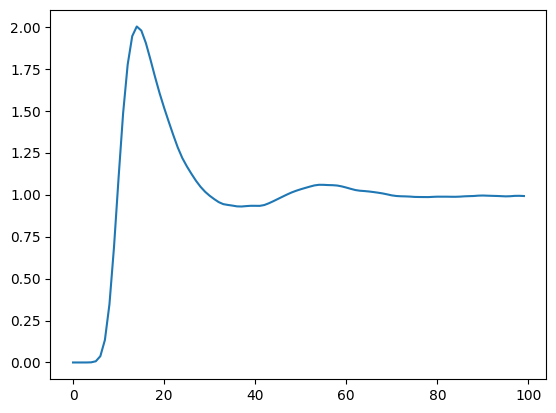

In [30]:
pair_data_dict = {  'lj_0.3_1.2': {
            'rdf_fn': './data/LJ_data/rdf_rho0.3_T1.2_dt0.01.csv' ,
            'vacf_fn': './data/LJ_data/vacf_rho0.3_T1.2_dt0.01.csv' ,
            'rho': 0.3,
            'T': 1.2, 
            'start': 0.75, 
            'end': 3.3,
            'element': "H",
            'mass': 1.0,
            "N_unitcell": 4,
            "cell": FaceCenteredCubic,
            "target_pot": LennardJones()
            },
  }

rdf_data_path = pair_data_dict['lj_0.3_1.2'].get("rdf_fn", None)
vacf_data_path = pair_data_dict['lj_0.3_1.2'].get("vacf_fn", None)
rdf_data = np.loadtxt(rdf_data_path, delimiter=',')
vacf_data = np.loadtxt(vacf_data_path, delimiter=',')
print(rdf_data)
_, rdf_target = get_exp_rdf(rdf_data, 100, (0.75, 3.3), 'cpu', dim=3)
plt.plot(rdf_target)


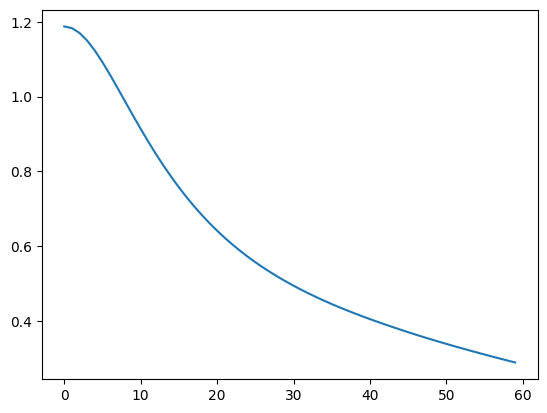

In [31]:
plt.plot(vacf_data)